# Purpose
- One model, 3 datasets
- Compare Lap, AIC, BIC and MCMC
- Explore details of Lap
- Figures I want:
    - Lap and MCMC overlaid on the likelihood function
    - Table comparing the 3 datasets for all metrics

In [271]:
import sys
sys.path.insert(1, "..")
import pprint
import gpytorch
import torch
import numpy as np
import metrics
import copy
import configparser
from experiment_functions import Experiment
from GaussianProcess import ExactGPModel
from globalParams import options, hyperparameter_limits
import gpytorch
from helpFunctions import get_string_representation_of_kernel as gsr
from helpFunctions import clean_kernel_expression
from helpFunctions import get_kernels_in_kernel_expression, get_full_kernels_in_kernel_expression
from helpFunctions import amount_of_base_kernels
from itertools import product
import json
from kernelSearch import *
from matplotlib import pyplot as plt
from metrics import *
from multiprocessing import Pool
import numpy as np
import os
import pdb
import pickle
import random
import tikzplotlib
import time
import torch
from tqdm import tqdm
from scipy.stats import multivariate_normal
import matplotlib as mpl
from pygranso.pygranso import pygranso
from pygranso.pygransoStruct import pygransoStruct
from pygranso.private.getNvar import getNvarTorch

# To run STAN in a Jupyter notebook
import nest_asyncio
nest_asyncio.apply()



torch.manual_seed(42)


In [272]:
torch.set_default_dtype(torch.float64)

# Helper functions

In [273]:
def random_reinit(model):
    for i, (param, limit) in enumerate(zip(model.parameters(), [{"Noise": hyperparameter_limits["Noise"]},*[hyperparameter_limits[kernel] for kernel in get_full_kernels_in_kernel_expression(model.covar_module)]])):
        covar_text = gsr(model.covar_module)
        param_name = list(limit.keys())[0]
        new_param_value = torch.randn_like(param) * (limit[param_name][1] - limit[param_name][0]) + limit[param_name][0]
        param.data = new_param_value



# Define the training loop
def optimize_hyperparameters2(model, likelihood, **kwargs):
    """
    find optimal hyperparameters either by BO or by starting from random initial values multiple times, using an optimizer every time
    and then returning the best result
    """
    log_param_path = kwargs.get("log_param_path", False)
    log_likelihood = kwargs.get("log_likelihood", False)
    random_restarts = kwargs.get("random_restarts", options["training"]["restarts"]+1)
    line_search = kwargs.get("line_search", False)
    BFGS_iter = kwargs.get("BFGS_iter", 50)
    train_iterations = kwargs.get("train_iterations", 0)
    train_x = kwargs.get("X", model.train_inputs)
    train_y = kwargs.get("Y", model.train_targets)
    with_BFGS = kwargs.get("with_BFGS", False)
    history_size = kwargs.get("history_size", 100)
    MAP = kwargs.get("MAP", True)
    prior = kwargs.get("prior", False)
    granso = kwargs.get("granso", True)

    # Set up the likelihood and model
    #likelihood = gpytorch.likelihoods.GaussianLikelihood()
    #model = GPModel(train_x, train_y, likelihood)

    # Define the negative log likelihood
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    # Set up the PyGRANSO optimizer
    opts = pygransoStruct()
    opts.torch_device = torch.device('cpu')
    nvar = getNvarTorch(model.parameters())
    opts.x0 = torch.nn.utils.parameters_to_vector(model.parameters()).detach().reshape(nvar,1)
    opts.opt_tol = float(1e-10)
    opts.limited_mem_size = int(100)
    opts.globalAD = True
    opts.quadprog_info_msg = False
    opts.print_level = int(0)
    opts.halt_on_linesearch_bracket = False

    # Define the objective function
    def objective_function(model):
        output = model(train_x)
        loss = -mll(output, train_y)
        log_p = log_normalized_prior(model)
        loss -= log_p
        return [loss, None, None]

    best_model_state_dict = model.state_dict()
    best_likelihood_state_dict = likelihood.state_dict()

    random_restarts = int(5)
    best_f = np.inf
    for restart in range(random_restarts):
        print(f"pre training parameters: {list(model.named_parameters())}")
        # Train the model using PyGRANSO
        soln = pygranso(var_spec=model, combined_fn=objective_function, user_opts=opts)
        if soln.final.f < best_f:
            best_f = soln.final.f
            best_model_state_dict = model.state_dict()
            best_likelihood_state_dict = likelihood.state_dict()
        print(f"post training (final): {list(model.named_parameters())} w. loss: {soln.final.f} (smaller=better)")
        random_reinit(model)

    model.load_state_dict(best_model_state_dict)
    likelihood.load_state_dict(best_likelihood_state_dict)

    loss = -mll(model(train_x), train_y)
    log_p = log_normalized_prior(model)
    loss -= log_p

    print(f"post training (best): {list(model.named_parameters())} w. loss: {soln.best.f}")
    print(f"post training (final): {list(model.named_parameters())} w. loss: {soln.final.f}")
    
    print(torch.autograd.grad(loss, [p for p in model.parameters()], retain_graph=True, create_graph=True, allow_unused=True))
    # Return the trained model
    return loss, model, likelihood


def get_std_points(mu, K):
    x, y = np.mgrid[float(-3):float(3):float(.1), float(-3):float(3):float(.1)]
    rv = multivariate_normal(mu, K)
    L = np.linalg.cholesky(K)

    data = np.dstack((x, y))
    z = rv.pdf(data)

    # Drawing the unit circle
    # x^2 + y^2 = 1
    precision = int(50)
    unit_x = torch.cat([torch.linspace(float(-1), float(1), precision), torch.linspace(float(-1), float(1), precision)])
    unit_y = torch.cat([torch.sqrt(float(1) - torch.linspace(float(-1), float(1), precision)**float(2)), -torch.sqrt(float(1) - torch.linspace(float(-1), float(1), precision)**float(2))])

    new_unit_x = list()
    new_unit_y = list()

    for tx, ty in zip(unit_x, unit_y):
        res = np.array([tx, ty]) @ L
        new_unit_x.append(mu[0] + float(2)*res[0])
        new_unit_y.append(mu[1] + float(2)*res[1])
    return new_unit_x, new_unit_y



In [274]:
# Globals
figure_path = "grad_figures"

# Data 

tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000])
tensor([0.1065, 0.1518, 0.2964, 0.4062, 0.0894, 0.4966, 1.3650, 0.5760, 1.0349,
        1.0845])


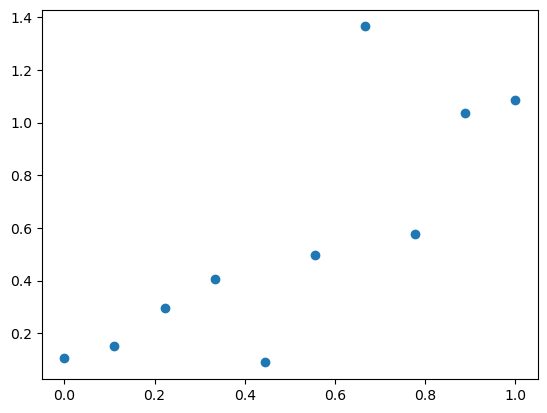

In [275]:
import math
torch.manual_seed(42)
END = 1
COUNT = 10
dataset_name = "noise_linear"
#dataset_name = "noise_sin"
#dataset_name = "noise_parabolic"
# linear
if "linear" in dataset_name:
    train_x = torch.linspace(0, END, COUNT)
    train_y = torch.linspace(0, END, COUNT)
    train_y += torch.randn(train_x.size()) * torch.sqrt(torch.tensor(0.1))
elif "sin" in dataset_name:
# sin
    train_x = torch.linspace(0, 1, COUNT)
    train_y = torch.sin(train_x * (2 * math.pi)) + torch.randn(train_x.size()) * torch.sqrt(torch.tensor(0.1)) 
##parabolic
elif "parabolic" in dataset_name:
    END = 2
    train_x = torch.linspace(-2, END, COUNT)
    train_y = train_x * train_x + 0.5 + torch.randn(train_x.size()) * torch.sqrt(torch.tensor(0.1)) 
plt.plot(train_x, train_y, "o")
print(train_x)
print(train_y)

plt.savefig(f"{figure_path}/data_{dataset_name}.png")
tikzplotlib.save(f"{figure_path}/data_{dataset_name}.tex")

# Model definition

In [276]:
model_name = "SE"
model_name = "SE+SE"
model_name = "LIN"
# Simplest GP possible. SE with constant sigma_f 
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood, model_name="SE"):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        if model_name == "SE":
            self.mean_module = gpytorch.means.ZeroMean()
            self.covar_module = gpytorch.kernels.RBFKernel()
        elif model_name == "SE+SE":
            self.mean_module = gpytorch.means.ZeroMean()
            self.covar_module = gpytorch.kernels.RBFKernel() + gpytorch.kernels.RBFKernel()
        elif model_name == "LIN":
            self.mean_module = gpytorch.means.ZeroMean()
            self.covar_module = gpytorch.kernels.LinearKernel()
        else:
            raise ValueError("Invalid model_name")

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
#likelihood = gpytorch.likelihoods.GaussianLikelihood(noise_constraint=gpytorch.constraints.GreaterThan(1e-30))
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x, train_y, likelihood, model_name=model_name)

# Training

In [277]:
num_train_iter = 0
use_MAP = True 
use_LBFGS = False
LBFGS_iter = 50
# Train the MAP for 100 Iterations of ADAM and then 50 more of L-BFGS
loss, model, likelihood = optimize_hyperparameters2(model, likelihood,
                                                    X=train_x, 
                                                    Y=train_y
                                                   )
#loss,  model, likelihood = optimize_hyperparameters(model, likelihood, 
#                                                                 line_search=False, 
#                                                                 X=train_x, 
#                                                                 Y=train_y, 
#                                                                 train_iterations=0, 
#                                                                 #BFGS_iter=LBFGS_iter, 
#                                                                 #history_size=2*LBFGS_iter, 
#                                                                 #with_BFGS=use_LBFGS, 
#                                                                 #MAP=use_MAP, 
#                                                                 log_param_path=False, 
#                                                                 random_restarts=1, 
#                                                                 log_likelihood=False)


pre training parameters: [('likelihood.noise_covar.raw_noise', Parameter containing:
tensor([0.], requires_grad=True)), ('covar_module.raw_variance', Parameter containing:
tensor([[0.]], requires_grad=True))]
post training (final): [('likelihood.noise_covar.raw_noise', Parameter containing:
tensor([-2.5901], requires_grad=True)), ('covar_module.raw_variance', Parameter containing:
tensor([[0.1731]], requires_grad=True))] w. loss: 0.6903684284287768 (smaller=better)
pre training parameters: [('likelihood.noise_covar.raw_noise', Parameter containing:
tensor([0.0581], requires_grad=True)), ('covar_module.raw_variance', Parameter containing:
tensor([[0.8094]], requires_grad=True))]
post training (final): [('likelihood.noise_covar.raw_noise', Parameter containing:
tensor([-2.5901], requires_grad=True)), ('covar_module.raw_variance', Parameter containing:
tensor([[0.1731]], requires_grad=True))] w. loss: 0.6903684284287768 (smaller=better)
pre training parameters: [('likelihood.noise_covar.r

In [278]:
loss

tensor(0.6904, grad_fn=<SubBackward0>)

In [279]:
list(model.named_parameters())

[('likelihood.noise_covar.raw_noise',
  Parameter containing:
  tensor([-2.5901], requires_grad=True)),
 ('covar_module.raw_variance',
  Parameter containing:
  tensor([[0.1731]], requires_grad=True))]

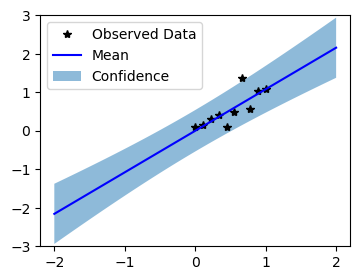

In [280]:
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

# Test points are regularly spaced along [0,1]
# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x = torch.linspace(-2, 2, 51)
    a = model(test_x)
    observed_pred = likelihood(a)
    
with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(4, 3))

    # Get upper and lower confidence bounds
    lower, upper = observed_pred.confidence_region()
    # Plot training data as black stars
    ax.plot(train_x.numpy(), train_y.numpy(), 'k*')
    # Plot predictive means as blue line
    ax.plot(test_x.numpy(), observed_pred.mean.numpy(), 'b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    ax.set_ylim([-3, 3])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])

plt.savefig(f"{figure_path}/{model_name}_{dataset_name}_posterior.png")
tikzplotlib.save(f"{figure_path}/{model_name}_{dataset_name}_posterior.tex")

# Laplace

In [281]:
#print(f"L-BFGS iterations: {len(training_log['log_likelihood']) - num_train_iter}")
model.train()
likelihood.train()
lap_approx_S, lap_log_S = metrics.calculate_laplace(model, -loss, with_prior=True, param_punish_term=0.0)
lap_approx_AIC, lap_log_AIC = metrics.calculate_laplace(model, -loss, with_prior=True, param_punish_term=-1.0)
lap_approx_BIC, lap_log_BIC = metrics.calculate_laplace(model, -loss, with_prior=True, param_punish_term="BIC")
print(lap_approx_S)
print(lap_log_S)
print(lap_approx_AIC)
print(lap_log_AIC)
print(lap_approx_BIC)
print(lap_log_BIC)

# Draw the distribution defined by the mean (found parametrization) and covariance matrix (Hessian)
# (4.133) in Bishop, 2006: f(z) ~ f(z_0)exp(-0.5 (z-z_0)^T H (z-z_0)) with z the parameters, and H the Hessian
# We just leave out the f(z_0)

#scaling_factor = lap_log["neg MLL"]
#mu = [p.item() for p in list(model.parameters())]
##mu = [training_log["log_param_path"][param_keys[0]][-1], training_log["log_param_path"][param_keys[1]][-1]]
#K = lap_log["corrected Hessian"]
#new_unit_x, new_unit_y = get_std_points(mu, K.inverse()[:2, :2])
#plt.scatter(new_unit_x, new_unit_y, color="grey", s=3)
#K = lap_log["original symmetrized Hessian"]
#new_unit_x, new_unit_y = get_std_points(mu, K.inverse()[:2, :2])
#plt.scatter(new_unit_x, new_unit_y, color="black", s=3)
#

trained_mu = [p.item() for p in list(model.parameters())]

tensor(-0.6904, dtype=torch.float64, grad_fn=<AddBackward0>)
{'neg MLL': tensor(0.6904, dtype=torch.float64, grad_fn=<NegBackward0>), 'punish term': tensor(-7.7066e-05, dtype=torch.float64), 'laplace without replacement': tensor(3.1971, dtype=torch.float64, grad_fn=<SubBackward0>), 'num_replaced': tensor(2), 'parameter list': ['likelihood.noise_covar.raw_noise', 'covar_module.raw_variance'], 'Jacobian': (tensor([-0.0124], dtype=torch.float64, grad_fn=<SoftplusBackwardBackward0>), tensor([[-0.0177]], dtype=torch.float64, grad_fn=<SoftplusBackwardBackward0>)), 'parameter values': tensor([[-2.5901],
        [ 0.1731]], dtype=torch.float64), 'corrected Hessian': tensor([[ 6.2832e+00, -3.4694e-18],
        [ 3.4694e-18,  6.2832e+00]], dtype=torch.float64), 'diag(constructed eigvals)': tensor([6.2832, 6.2832], dtype=torch.float64), 'original symmetrized Hessian': tensor([[0.4288, 0.0017],
        [0.0017, 0.0387]], dtype=torch.float64), 'prior mean': tensor([[-3.5164],
        [-0.8018]], dt

/home/besginow/code/LaplaceKernelSearch/exploration_tests/../metrics.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  [max(val, (torch.exp(torch.tensor(-2*param_punish_term))*(2*torch.pi))) for i, val in enumerate(vals)]))


In [282]:
AIC_approx, AIC_log = calculate_AIC(-loss*len(train_x), len(trained_mu))
print(AIC_approx)
print(AIC_log)

tensor(-17.8074, dtype=torch.float64, grad_fn=<AddBackward0>)
{'punish term': 4, 'Total time': 1.3589859008789062e-05, 'loss term': tensor(-13.8074, dtype=torch.float64, grad_fn=<MulBackward0>)}


In [283]:
BIC_approx, BIC_log = calculate_BIC(-loss*len(train_x), len(trained_mu), torch.tensor(len(train_x)))
print(BIC_approx)
print(BIC_log)

tensor(-18.4125, dtype=torch.float64, grad_fn=<AddBackward0>)
{'punish term': tensor(-4.6052), 'Total time': 5.555152893066406e-05, 'loss term': tensor(-13.8074, dtype=torch.float64, grad_fn=<MulBackward0>)}


# MCMC

In [284]:
from metrics import calculate_mc_STAN
# Perform MCMC
MCMC_approx, MC_log = calculate_mc_STAN(
    model, likelihood, 1000, log_param_path=True, 
    log_full_likelihood=True, log_full_posterior=True)
print(MCMC_approx)

Building...



Building: found in cache, done.Messages from stanc:
Warning in '/tmp/httpstan_kwdosatl/model_trvv2j5x.stan', line 5, column 12: A
    control flow statement inside function softplus depends on argument v. At
    '/tmp/httpstan_kwdosatl/model_trvv2j5x.stan', line 32, column 90 to
    column 98, the value of v depends on parameter(s): theta.
Warning in '/tmp/httpstan_kwdosatl/model_trvv2j5x.stan', line 5, column 12: A
    control flow statement inside function softplus depends on argument v. At
    '/tmp/httpstan_kwdosatl/model_trvv2j5x.stan', line 32, column 112 to
    column 120, the value of v depends on parameter(s): theta.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling: 100% (2000/2000)
Sampling: 100% (2000/2000), done.
Messages received during sampling:
  Gradient evaluation took 1.5e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.15 seconds.
  Adjust your expec

tensor(-4.1255)


In [285]:
# w. 0 ADAM (MAP)
#[('likelihood.noise_covar.raw_noise', Parameter containing:
#tensor([-11.8925], requires_grad=True)), ('covar_module.raw_lengthscale', Parameter containing:
#tensor([[1.7432]], requires_grad=True))]
# w. 50 ADAM
# [('likelihood.noise_covar.raw_noise', Parameter containing:
# tensor([-11.6812], requires_grad=True)), ('covar_module.raw_lengthscale', Parameter containing:
# tensor([[1.5973]], requires_grad=True))]
# w. 100 ADAM
# [('likelihood.noise_covar.raw_noise', Parameter containing:
# tensor([-10.8088], requires_grad=True)), ('covar_module.raw_lengthscale', Parameter containing:
# tensor([[1.8571]], requires_grad=True))]

#max_index = MC_log['manual lp list'].index(max(MC_log['manual lp list']))
#for i, param in enumerate(MC_log['param draws dict']):
#    print(f"{lap_log['parameter list'][i]}:{MC_log['param draws dict'][param][max_index]}")

# MC Figures

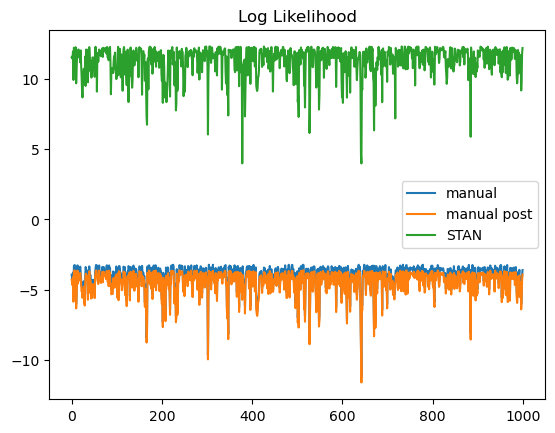

In [286]:
plt.plot(MC_log['manual lp list'])
plt.plot(MC_log["manual post list"])
plt.plot(MC_log["STAN_like_approx"])
plt.legend(["manual", "manual post", "STAN"])
plt.title("Log Likelihood")
plt.savefig(f"{figure_path}/{model_name}_{dataset_name}_log_likelihood_MCMC_draws.png")
tikzplotlib.save(f"{figure_path}/{model_name}_{dataset_name}_log_likelihood_MCMC_draws.tex")

{'theta.1': {'mu': -2.433637992882215, 'var': 0.28747082927111056},
 'theta.2': {'mu': -0.3077824028743499, 'var': 0.5733216930155681}}
{'mu': tensor([[-3.5164],
        [-0.8018]]), 'var': tensor([[12.8388,  0.0000],
        [ 0.0000,  0.9933]])}


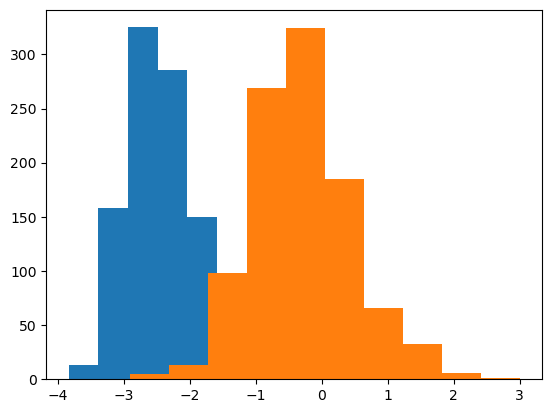

In [287]:

import pprint
pprint.pprint(MC_log["Parameter statistics"])
for param_name in MC_log['param draws dict']:
    plt.hist(MC_log['param draws dict'][param_name])
print(MC_log["Parameter prior"])
plt.savefig(f"{figure_path}/{model_name}_{dataset_name}_MCMC_param_distribution.png")
tikzplotlib.save(f"{figure_path}/{model_name}_{dataset_name}_MCMC_param_distribution.tex")

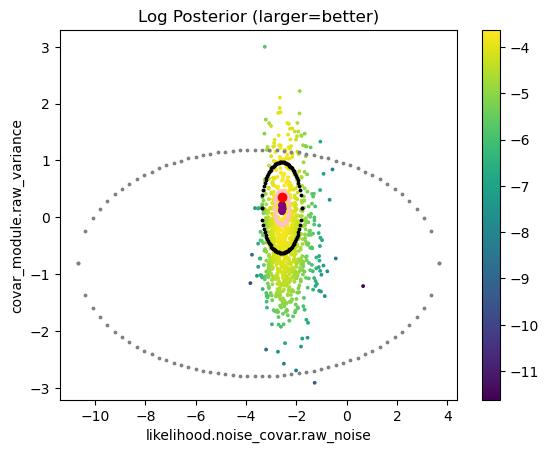

In [288]:
#
#scaling_factor = lap_log["neg MLL"]
#mu = [training_log["training_log"][param_keys[0]][-1], training_log["training_log"][param_keys[1]][-1]]
#K = lap_log["corrected Hessian"]
#new_unit_x, new_unit_y = get_std_points(mu, K)
##plt.scatter(new_unit_x, new_unit_y, color="grey", s=3)
#K = lap_log["original symmetrized Hessian"]
#new_unit_x, new_unit_y = get_std_points(mu, K)
#plt.scatter(new_unit_x, new_unit_y, color="black", s=3)
#

def get_sub_tensor(tensor, num1, num2):
    sub_tensor = tensor[[num1, num2]][:, [num1, num2]]
    return sub_tensor


draw_prior=False
draw_uncorrected=False

#what_to_draw = "manual lp list" # likelihood surface 
what_to_draw = "manual post list" # posterior surface
#what_to_draw = "STAN_like_approx" # STAN likelihood surface

param_names = [param[0] for param in model.named_parameters()]

plot_param1 = "theta.1" 
plot_param2 = "theta.2" 
row_num = int(plot_param1[-1:]) - int(1) 
col_num = int(plot_param2[-1:]) - int(1)


filtered = False 
filtered_noise = list()
filtered_length = list()
filtered_loglike = list()

# loop to filter draws below X 
for n, l, llik in zip(MC_log['param draws dict'][plot_param1], MC_log['param draws dict'][plot_param2], MC_log[what_to_draw]):
    if llik > int(-100):
        filtered_noise.append(n)
        filtered_length.append(l)
        filtered_loglike.append(llik)

if filtered:
    for i in range(len(filtered_noise)-1):
        n, l = filtered_noise[i], filtered_length[i]
        n2, l2 = filtered_noise[i+1], filtered_length[i+1]
        #plt.arrow(n, l, n2-n, l2-l, color=mpl.colormaps["Greens"](i/len(filtered_noise)), head_length = 0.07, head_width = 0.025, length_includes_head = True)
    plt.scatter(filtered_noise, filtered_length, c=filtered_loglike, s=3)
    max_index = MC_log[what_to_draw].index(max(MC_log[what_to_draw]))
    #print(f"{max(MC_log[what_to_draw])} : {MC_log['param draws dict']['theta.1'][max_index]} {MC_log['param draws dict']['theta.2'][max_index]}")
    plt.plot(MC_log['param draws dict'][plot_param1][max_index], MC_log['param draws dict'][plot_param2][max_index], "ro")
else:
    for i in range(len(MC_log['param draws dict'][plot_param1])-1):
        n, l = MC_log['param draws dict'][plot_param1][i], MC_log['param draws dict'][plot_param2][i]
        n2, l2 = MC_log['param draws dict'][plot_param1][i+int(1)], MC_log['param draws dict'][plot_param2][i+int(1)]
        #plt.arrow(n, l, n2-n, l2-l, color=mpl.colormaps["Greens"](i/len(MC_log['param draws dict'][plot_param1])), head_length = 0.07, head_width = 0.025, length_includes_head = True)
    plt.scatter(MC_log['param draws dict'][plot_param1], MC_log['param draws dict'][plot_param2], c=torch.Tensor(MC_log[what_to_draw]), s=3)
    max_index = MC_log[what_to_draw].index(max(MC_log[what_to_draw]))
    plt.plot(MC_log['param draws dict'][plot_param1][max_index], MC_log['param draws dict'][plot_param2][max_index], "ro")


plt.colorbar()


mu = torch.tensor(trained_mu)[[row_num, col_num]]
K = lap_log_S["corrected Hessian"]
new_unit_x, new_unit_y = get_std_points(mu, get_sub_tensor(K.inverse(), row_num, col_num))
plt.scatter(new_unit_x, new_unit_y, color="black", s=3)

K = lap_log_AIC["corrected Hessian"]
new_unit_x, new_unit_y = get_std_points(mu, get_sub_tensor(K.inverse(), row_num, col_num))
plt.scatter(new_unit_x, new_unit_y, color="pink", s=3)

K = lap_log_BIC["corrected Hessian"]
new_unit_x, new_unit_y = get_std_points(mu, get_sub_tensor(K.inverse(), row_num, col_num))
plt.scatter(new_unit_x, new_unit_y, color="purple", s=3)


new_unit_x, new_unit_y = get_std_points(MC_log["Parameter prior"]["mu"].flatten()[[row_num, col_num]], get_sub_tensor(MC_log["Parameter prior"]["var"], row_num, col_num))
if draw_prior or what_to_draw == "manual post list": 
    plt.scatter(new_unit_x, new_unit_y, color="gray", s=3)
K = lap_log_S["original symmetrized Hessian"]
try:
    new_unit_x, new_unit_y = get_std_points(mu, get_sub_tensor(K.inverse(), row_num, col_num))
    if draw_uncorrected: 
        plt.scatter(new_unit_x, new_unit_y, color="turquoise", s=3)
except: 
    pass
plt.xlabel(param_names[row_num])
plt.ylabel(param_names[col_num])
plt.title(f"Log {'Likelihood' if 'lp' in what_to_draw else 'Posterior'} (larger=better)")

plt.savefig(f"{figure_path}/{model_name}_{dataset_name}_MCMC_{'likelihood' if 'lp' in what_to_draw else 'posterior'}_surface_{param_names[row_num]}-{param_names[col_num]}.png")
tikzplotlib.save(f"{figure_path}/{model_name}_{dataset_name}_MCMC_{'likelihood' if 'lp' in what_to_draw else 'posterior'}_surface_{param_names[row_num]}-{param_names[col_num]}.tex")

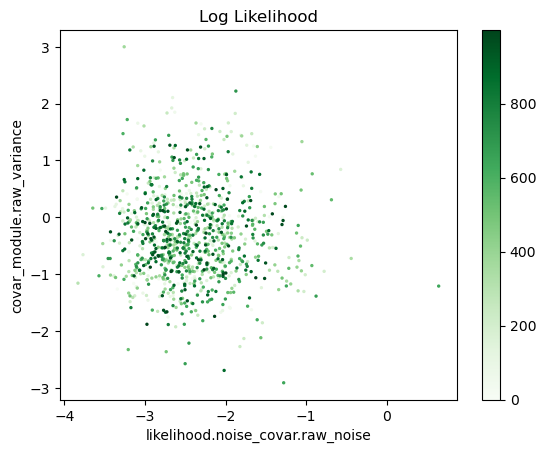

In [289]:
# Contour plot of the likelihood surface according to the explored samples
# loop to filter draws below -5000
#plot_param1 = "theta.2" 
#plot_param2 = "theta.3" 
#row_num = int(plot_param1[-1:]) - int(1) 
#col_num = int(plot_param2[-1:]) - int(1)


filtered_noise = list()
filtered_length = list()
filtered_loglike = list()
for n, l, llik in zip(MC_log['param draws dict'][plot_param1], MC_log['param draws dict'][plot_param2], MC_log[what_to_draw]):
    if llik > int(-5000):
        filtered_noise.append(n)
        filtered_length.append(l)
        filtered_loglike.append(llik)
plt.scatter(MC_log['param draws dict'][plot_param1], MC_log['param draws dict'][plot_param2], c=range(len(MC_log['param draws dict'][plot_param2])), cmap="Greens", s=2)
plt.colorbar() 
## Drawing the parameter Prior
#new_unit_x, new_unit_y = get_std_points(MC_log["Parameter prior"]["mu"].numpy().T[0][:2], MC_log["Parameter prior"]["var"].inverse()[:2, :2])
# Draw one standard deviation around the center of the distribution
#plt.scatter(new_unit_x, new_unit_y, color="pink", s=3)
#plt.scatter(filtered_noise, filtered_length, c=filtered_loglike)

plt.xlabel(param_names[row_num])
plt.ylabel(param_names[col_num])
plt.title("Log Likelihood")

plt.savefig(f"{figure_path}/{model_name}_{dataset_name}_MCMC_likelihood_path_{param_names[row_num]}-{param_names[col_num]}.png")
tikzplotlib.save(f"{figure_path}/{model_name}_{dataset_name}_MCMC_likelihood_path_{param_names[row_num]}-{param_names[col_num]}.tex")

In [290]:
print(f"{model_name}")
print(f"data & LODE model & MCMC & Lap\\_0 & Lap\\_AIC & Lap\\_BIC & AIC & BIC & MLL\\\\")
print(f"{dataset_name} & {model_name} & {MCMC_approx:.2f} & {lap_approx_S:.2f} & {lap_approx_AIC:.2f} & {lap_approx_BIC:.2f} & {-AIC_approx:.2f} & {-BIC_approx:.2f} & {-loss*model.train_targets.numel():.2f}\\\\")


with open(f"{figure_path}/results.txt", 'a+') as file:
    file.write(f"{model_name}\n")
    file.write(f"data & LODE model & MCMC & Lap\\_0 & Lap\\_AIC & Lap\\_BIC & AIC & BIC & MLL\\\\\n")
    file.write(f"{dataset_name} & {model_name} & {MCMC_approx:.2f} & {lap_approx_S:.2f} & {lap_approx_AIC:.2f} & {lap_approx_BIC:.2f} & {-AIC_approx:.2f} & {-BIC_approx:.2f} & {-loss*model.train_targets.numel():.2f}\\\\")



LIN
data & LODE model & MCMC & Lap\_0 & Lap\_AIC & Lap\_BIC & AIC & BIC & MLL\\
noise_linear & LIN & -4.13 & -0.69 & -2.69 & -5.30 & 17.81 & 18.41 & -6.90\\


In [291]:
dataset_name

'noise_linear'

In [292]:
import torch
print(torch.nn.functional.softplus(torch.sum(torch.linspace(0, 1, 10))))
print(torch.sum(torch.nn.functional.softplus(torch.linspace(0, 1, 10))))

tensor(5.0067)
tensor(9.8597)
